### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [3]:
import oci
import pandas as pd
from ipymarkup import show_ascii_markup
from ipymarkup import show_box_markup
from matplotlib import pyplot as plt
from ipymarkup.palette import palette, BLUE, RED, GREEN, ORANGE, PURPLE

In [4]:
Data = pd.read_csv('Data.csv')
for i in range(Data['Reviews'].size):
    if(len(Data['Reviews'][i])>1000):
        Data['Reviews'][i] = (Data['Reviews'][i])[:1000]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
Data.head(2)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,Reviews,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWV8VsCtRxPSIh2RyTvS,2018-08-27T17:01:16Z,2019-05-20T21:40:08Z,610 Poydras St,"Building,Hotels and motels,Hotel",Accommodation & Food Services,New Orleans,US,us/la/neworleans/610poydrasst/-946012914,29.949125,...,"2018-11-06T00:00:00Z,2018-08-26T00:00:00Z",3,https://www.tripadvisor.com/Hotel_Review-g6086...,The water is very hot and there's no cold wate...,"Very hot water, bad food",Honolulu,Hawaii,Stacy D,https://www.tripadvisor.com/Hotel_Review-g6086...,"http://www.whitneyhotel.com/,http://www.whitne..."
1,AWV8VsCtRxPSIh2RyTvS,2018-08-27T17:01:16Z,2019-05-20T21:40:08Z,610 Poydras St,"Building,Hotels and motels,Hotel",Accommodation & Food Services,New Orleans,US,us/la/neworleans/610poydrasst/-946012914,29.949125,...,2018-11-06T00:00:00Z,5,https://www.tripadvisor.com/Hotel_Review-g6086...,Great staff and rooms. Housekeeping was always...,Excellent hotel,New York City,NewYork,brand0nstark,https://www.tripadvisor.com/Hotel_Review-g6086...,"http://www.whitneyhotel.com/,http://www.whitne..."


In [8]:
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file(),
                                             service_endpoint="https://language-preprod.aiservice.us-phoenix-1.oci.oraclecloud.com")

In [9]:
result=[]
for data in Data.Reviews:
    detect_language_entities_details = oci.ai_language.models.DetectLanguageEntitiesDetails(text=data)
    output = ai_client.detect_language_entities(detect_language_entities_details)
    result += [output.data]

In [425]:
# Process all the reviews for the particular property.
# Ask user if they want all for PII or not
# Ask user if they want all entitiy or all Entities.

In [10]:
#Set the variable below to true if you only want PII
show_PII = False

In [11]:
# no_of_sentences = len(result)
no_of_sentences = 10
DataTemp=Data
for res in range(no_of_sentences):
    spans=[]
    show_sen=False
    if show_PII:
        for i in result[res].entities:
            if i.is_pii:
                show_sen=True
                spans += [(i.offset, i.offset+i.length, i.type+"(PII)")]
                temp_str = Data.Reviews[res][i.offset:i.offset+i.length]
                DataTemp.Reviews[res] = DataTemp.Reviews[res].replace(temp_str, "*" * i.length)
    else:
        show_sen=True
        for i in result[res].entities:
            if i.is_pii:
                spans += [(i.offset, i.offset+i.length, i.type+"(PII)")]
            else:
                spans += [(i.offset, i.offset+i.length, i.type)]
    if show_sen:
        if show_PII:
            show_box_markup(DataTemp.Reviews[res], spans)
        else:
            show_box_markup(Data.Reviews[res], spans)
        print()

In [344]:
#1. Ask user if 

In [13]:
# build out a data frame of all the named entities and their types
no_of_sentences = len(result)
# no_of_sentences = 1
named_entities=[]
for res in range(no_of_sentences):
    spans=[]
    for i in result[res].entities:
        temp_named_entity = (i.text, i.type)
        named_entities.append(temp_named_entity)
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [14]:
# transform and aggregate the data frame to find the top occuring entities and types.
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

In [15]:
no_of_top_entities=15
top_entities.iloc[:no_of_top_entities,:]

,Entity Name,Entity Type,Frequency
0,room,FAC,202
1,San Diego,GPE,77
2,pool,FAC,62
3,one,CARDINAL,59
4,restaurant,FAC,50
5,New Orleans,GPE,46
6,two,CARDINAL,43
7,Whitney Hotel,FAC,38
8,bit,QUANTITY,35
9,bed,PRODUCT,32


In [16]:
# transform and aggregate the data frame to find the top occuring entities types.
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

In [17]:
no_of_top_entities = top_entities['Entity Type'].size
top_entities.iloc[:no_of_top_entities,:]

,Entity Type,Frequency
0,PRODUCT,710
1,FAC,665
2,CARDINAL,269
3,GPE,238
4,TIME,219
5,DATE,162
6,PERSON,125
7,ORG,95
8,EVENT,58
9,QUANTITY,44


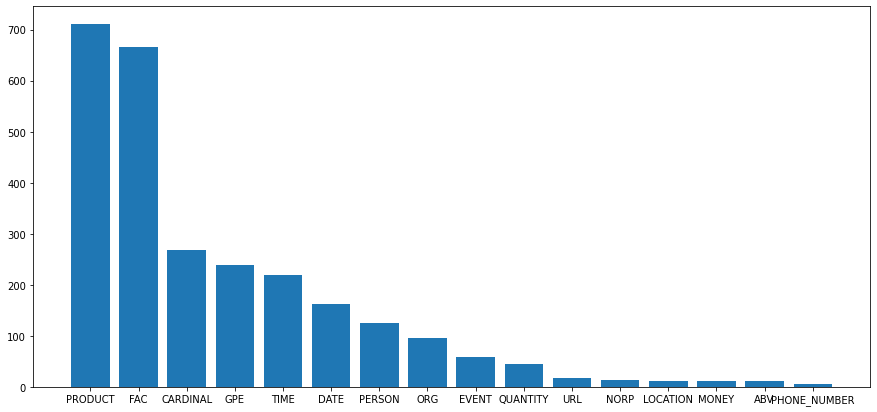

In [18]:
# Horizontal Bar Plot
fig = plt.figure(figsize =(15, 7))
plt.bar(top_entities['Entity Type'], top_entities['Frequency'])
# Show Plot
plt.show()